# **Functions**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

In [2]:
def bernoulli_log_pdf(x, mu):
    eps = 1e-10 
    log_prob = x[:, None, :] * np.log(mu[None, :, :] + eps) + \
               (1 - x[:, None, :]) * np.log(1 - mu[None, :, :] + eps)
    return np.sum(log_prob, axis=2)

def em_bernoulli_mixture(X, K=4, max_iter=100):
    N, D = X.shape
    log_likelihoods = []

    np.random.seed()
    pi = np.full(K, 1/K)
    mu = np.random.rand(K, D)

    for iteration in range(max_iter):
        log_prob = bernoulli_log_pdf(X, mu)
        log_prob += np.log(pi + 1e-10)
        log_sum = np.logaddexp.reduce(log_prob, axis=1, keepdims=True)
        log_resp = log_prob - log_sum
        resp = np.exp(log_resp)

        Nk = resp.sum(axis=0)
        pi = Nk / N
        mu = (resp.T @ X) / (Nk[:, None] + 1e-10)

        ll = np.sum(log_sum)
        log_likelihoods.append(ll)

    return pi, mu, log_likelihoods

In [3]:
def gaussian_pdf(x, mean, cov):
    D = len(x)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    num = np.exp(-0.5 * (x - mean).T @ inv @ (x - mean))
    den = np.sqrt((2 * np.pi) ** D * det + 1e-10)
    return num / den

In [4]:
def run_em_gmm(X, K, max_iter):
    N, D = X.shape
    np.random.seed()
    means = X[np.random.choice(N, K, replace=False)]
    covs = np.array([np.eye(D) for _ in range(K)])
    pis = np.ones(K) / K

    log_likelihoods = []

    for it in range(max_iter):
        resp = np.zeros((N, K))
        for k in range(K):
            for i in range(N):
                resp[i, k] = pis[k] * gaussian_pdf(X[i], means[k], covs[k])
        resp /= resp.sum(axis=1, keepdims=True) + 1e-10

        Nk = resp.sum(axis=0)
        pis = Nk / N
        for k in range(K):
            means[k] = (resp[:, k].reshape(-1, 1) * X).sum(axis=0) / Nk[k]
            diff = X - means[k]
            covs[k] = (resp[:, k].reshape(-1, 1) * diff).T @ diff / Nk[k]
            covs[k] += np.eye(D) * 1e-6  # regularization

        ll = 0
        for i in range(N):
            tmp = 0
            for k in range(K):
                tmp += pis[k] * gaussian_pdf(X[i], means[k], covs[k])
            ll += np.log(tmp + 1e-10)
        log_likelihoods.append(ll / N)

    return np.array(log_likelihoods)

In [5]:
def euclidean_distance(row1, row2, feature_cols):
    return sum((row1[col] - row2[col]) ** 2 for col in feature_cols) ** 0.5

In [6]:
def K_means(df, K, plusplus=False):

    errors = []

    df_copy = df.copy()
    feature_cols = [col for col in df.columns]

    if not plusplus:
        centroids = df_copy.sample(n=K).copy()
        centroids['cluster'] = range(1, K + 1)
    else:
        pass

    while True:
        old_cluster_assignments = df_copy['cluster'].copy() if 'cluster' in df_copy else None

        # Assign points to nearest centroid
        clusters = []
        for _, row in df_copy.iterrows():
            min_dist = float('inf')
            assigned_cluster = None
            for _, centroid_row in centroids.iterrows():
                dist = euclidean_distance(row, centroid_row, feature_cols)
                if dist < min_dist:
                    min_dist = dist
                    assigned_cluster = centroid_row['cluster']
            clusters.append(assigned_cluster)

        df_copy['cluster'] = clusters

        # Compute new centroids
        new_centroids = df_copy.groupby('cluster')[feature_cols].mean().reset_index()

        # Compute current iteration error (objective)
        error = 0
        for _, row in df_copy.iterrows():
            centroid_row = new_centroids[new_centroids['cluster'] == row['cluster']].iloc[0]
            error += sum((row[col] - centroid_row[col]) ** 2 for col in feature_cols)
        errors.append(error)

        # Check for convergence
        if old_cluster_assignments is not None and df_copy['cluster'].equals(old_cluster_assignments):
            break

        centroids = new_centroids

    return df_copy, centroids, errors

In [7]:
class LinReg():
    def __init__(self):
        self.w = None
        self.w_history = []
        self.cost = None

    def Fit(self, Xo, Y, method=None, regularize=None, alpha=0.001, max_iter=10000, lambda_=1, capture_cost=False, tol=1e-6, batch_size=100, epoch=20):
        X = Xo.copy()
        X.insert(0, "bias", 1)
        X = X.to_numpy()
        Y = Y.to_numpy().reshape(-1, 1)
        m, n = X.shape

        self.w = np.zeros((n, 1))
        self.w_history = []

        rng = np.random.default_rng()

        def List_mean(a):
            return sum(a) / len(a)

        if method == 'Stoc_GD':
            for _ in range(max_iter):
                i = rng.integers(0, m)
                Xi = X[i:i+1]
                Yi = Y[i:i+1]

                grad = Xi.T @ (Xi @ self.w - Yi)

                if regularize == "Ridge":
                    reg_term = np.zeros_like(self.w)
                    reg_term[1:] = (lambda_ / m) * self.w[1:]
                    grad += reg_term

                self.w -= alpha * grad

                if capture_cost:
                    full_pred = X @ self.w
                    self.cost = np.sum((Y - full_pred) ** 2)
                    self.w_history.append(self.w.copy())

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            return (self.w, self.w_history) if capture_cost else self.w

        elif method == 'MiniBatch_GD':
            for epoch_idx in range(epoch):
                indices = rng.permutation(m)
                X_shuffled = X[indices]
                Y_shuffled = Y[indices]

                for start in range(0, m, batch_size):
                    end = start + batch_size
                    Xi = X_shuffled[start:end]
                    Yi = Y_shuffled[start:end]

                    grad = Xi.T @ (Xi @ self.w - Yi) / Xi.shape[0]

                    if regularize == "Ridge":
                        reg_term = np.zeros_like(self.w)
                        reg_term[1:] = (lambda_ / m) * self.w[1:]
                        grad += reg_term

                    self.w -= alpha * grad

                    if capture_cost:
                        full_pred = X @ self.w
                        self.cost = np.sum((Y - full_pred) ** 2)
                        self.w_history.append(self.w.copy())

                    if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                        break

            return (self.w, self.w_history) if capture_cost else self.w

        elif method == 'Batch_GD':
            for epoch_idx in range(epoch):
                grad = (X.T @ (X @ self.w - Y)) / m

                if regularize == "Ridge":
                    reg_term = np.zeros_like(self.w)
                    reg_term[1:] = (lambda_ / m) * self.w[1:]
                    grad += reg_term

                self.w -= alpha * grad

                if capture_cost:
                    full_pred = X @ self.w
                    self.cost = np.sum((Y - full_pred) ** 2)
                    self.w_history.append(self.w.copy())

                if len(self.w_history) > 1 and np.linalg.norm(self.w_history[-1] - self.w_history[-2]) < tol:
                    break

            return (self.w, self.w_history) if capture_cost else self.w

    
        else:
            tra = X.T
            try:
                self.w = np.linalg.inv(tra @ X) @ tra @ Y
            except np.linalg.LinAlgError:
                self.w = np.linalg.pinv(tra @ X) @ tra @ Y
            return self.w

    def Test(self, X_test):
        if self.w is None:
            raise Exception("Training Not yet Done")
        X_test = X_test.copy()
        X_test.insert(0, "bias", 1)
        X_test = X_test.to_numpy()
        y_pred = X_test @ self.w
        return y_pred

    def Eval(self, Y_Pred, Y_test):
        Y_Pred = np.array(Y_Pred).reshape(-1)
        Y_test = np.array(Y_test).reshape(-1)
        y_mean = np.mean(Y_test)
        ss_res = np.sum((Y_test - Y_Pred) ** 2)
        ss_tot = np.sum((Y_test - y_mean) ** 2)
        R = 1 - (ss_res / ss_tot)
        return R


In [8]:
def ridge_gd(X, y, alpha=0.001, lambda_=0.1, epochs=10000):
    N, d = X.shape
    w = np.zeros((d,1))
    for _ in range(epochs):
        y_pred = X @ w
        grad = (1/N) * (X.T @ (y_pred - y)) + lambda_ * w
        w -= alpha * grad
    return w

def cross_validate(X, y, lambdas, k=5, alpha=0.001, epochs=10000):
    N = X.shape[0]
    fold_size = N // k
    errors = []

    for lambda_ in lambdas:
        fold_errors = []
        for i in range(k):
            start, end = i*fold_size, (i+1)*fold_size
            X_val, y_val = X[start:end], y[start:end]
            X_train = np.vstack((X[:start], X[end:]))
            y_train = np.vstack((y[:start], y[end:]))

            w = ridge_gd(X_train, y_train, alpha=alpha, lambda_=lambda_, epochs=epochs)
            y_pred = X_val @ w
            fold_errors.append(mse(y_val, y_pred))
        errors.append(np.mean(fold_errors))
    return errors

In [9]:
def mse(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean((y_true - y_pred) ** 2)


def cross_validate_linreg(X_train_df, y_train_df, lambdas, k=5, alpha=0.001, max_iter=10000):
    N = len(X_train_df)
    fold_size = N // k
    errors = []

    for lambda_ in lambdas:
        fold_errors = []
        for i in range(k):
            start, end = i * fold_size, (i + 1) * fold_size

            X_val = X_train_df.iloc[start:end]
            y_val = y_train_df.iloc[start:end]
            X_tr = X_train_df.drop(X_train_df.index[start:end])
            y_tr = y_train_df.drop(y_train_df.index[start:end])

            model = LinReg()
            model.Fit(X_tr, y_tr, method='Batch_GD', regularize='Ridge', alpha=alpha,
                      max_iter=max_iter, lambda_=lambda_)
            y_pred = model.Test(X_val).reshape(-1)
            fold_errors.append(mse(y_val, y_pred))
        errors.append(np.mean(fold_errors))

    return errors


# Import

In [10]:
from aquarel import load_theme
import matplotlib.style as mplstyle
mplstyle.core.USER_LIBRARY_PATHS.append('/home/kb/anaconda3/envs/myenv/lib/python3.13/site-packages/aquarel/styles')

In [11]:
df1 = pd.read_csv("A2Q1.csv", header=None)
df2_test = pd.read_csv("A2Q2test.csv", header=None)
df2_train = pd.read_csv("A2Q2train.csv", header=None)

In [12]:
df2 = df2_train

In [13]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df1.shape

(400, 50)

In [15]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.58351,0.37939,0.83975,0.086861,0.61192,0.39203,0.189640,0.585090,0.89494,0.393850,...,0.51706,0.20535,0.829990,0.24995,0.31980,0.19674,0.958550,0.84948,0.92369,1.9741
1,0.86622,0.45135,0.93479,0.235810,0.50488,0.49742,0.117220,0.574880,0.71051,0.336890,...,0.27412,0.46065,0.655440,0.56656,0.49062,0.19920,0.320680,0.41419,0.83023,2.3354
2,0.39142,0.91995,0.13873,0.991810,0.54367,0.98449,0.340260,0.206470,0.40131,0.128990,...,0.27247,0.38911,0.799490,0.57753,0.86682,0.69741,0.628630,0.29479,0.54280,2.2053
3,0.79553,0.27854,0.22890,0.789290,0.49222,0.67084,0.769410,0.057104,0.20393,0.086936,...,0.24901,0.65976,0.943350,0.41246,0.92715,0.11015,0.101310,0.66801,0.34573,2.0400
4,0.65223,0.96665,0.17985,0.354060,0.84042,0.92891,0.014597,0.229530,0.43920,0.548940,...,0.93277,0.23674,0.027077,0.27111,0.23366,0.56356,0.047289,0.62792,0.97930,2.2053


In [16]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.58351,0.37939,0.83975,0.086861,0.61192,0.39203,0.189640,0.585090,0.89494,0.393850,...,0.51706,0.20535,0.829990,0.24995,0.31980,0.19674,0.958550,0.84948,0.92369,1.9741
1,0.86622,0.45135,0.93479,0.235810,0.50488,0.49742,0.117220,0.574880,0.71051,0.336890,...,0.27412,0.46065,0.655440,0.56656,0.49062,0.19920,0.320680,0.41419,0.83023,2.3354
2,0.39142,0.91995,0.13873,0.991810,0.54367,0.98449,0.340260,0.206470,0.40131,0.128990,...,0.27247,0.38911,0.799490,0.57753,0.86682,0.69741,0.628630,0.29479,0.54280,2.2053
3,0.79553,0.27854,0.22890,0.789290,0.49222,0.67084,0.769410,0.057104,0.20393,0.086936,...,0.24901,0.65976,0.943350,0.41246,0.92715,0.11015,0.101310,0.66801,0.34573,2.0400
4,0.65223,0.96665,0.17985,0.354060,0.84042,0.92891,0.014597,0.229530,0.43920,0.548940,...,0.93277,0.23674,0.027077,0.27111,0.23366,0.56356,0.047289,0.62792,0.97930,2.2053


In [17]:
df2.shape

(10000, 101)

## **Question1**

### (i)

In [18]:
X = df1.values.astype(np.float64)

In [19]:
max_iter = 50
avg_ll = np.zeros(max_iter)

In [20]:
for run in range(100):
    _, _, ll = em_bernoulli_mixture(X, K=4, max_iter=50)
    avg_ll += np.array(ll)

avg_ll /= 100

In [21]:
plt.style.use('./pitayasmoothie-light.mplstyle')

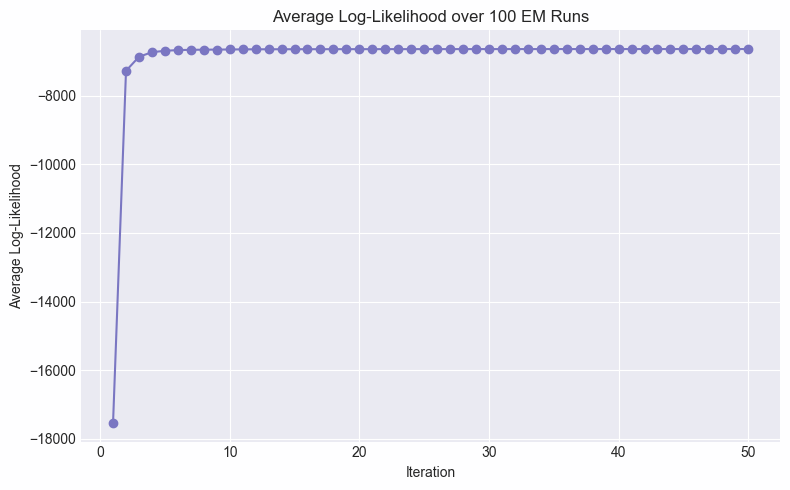

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_iter + 1), avg_ll, marker='o')
plt.title("Average Log-Likelihood over 100 EM Runs")
plt.xlabel("Iteration")
plt.ylabel("Average Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.show()

### (ii)

In [23]:
data = df1.values
N, D = data.shape
K = 4
max_iter = 20
n_init = 100

In [24]:
all_logs = np.zeros((n_init, max_iter))
for r in range(n_init):
    all_logs[r] = run_em_gmm(data, K, max_iter)

avg_log = all_logs.mean(axis=0)

In [25]:
avg_log

array([-22.93989644, -22.16552531, -22.01927521, -22.00628787,
       -22.00551068, -22.00500815, -22.00486195, -22.00470024,
       -22.00457925, -22.00464743, -22.00470717, -22.00448507,
       -22.0044059 , -22.00452322, -22.00431794, -22.00437717,
       -22.00431866, -22.00449814, -22.00428097, -22.00450811])

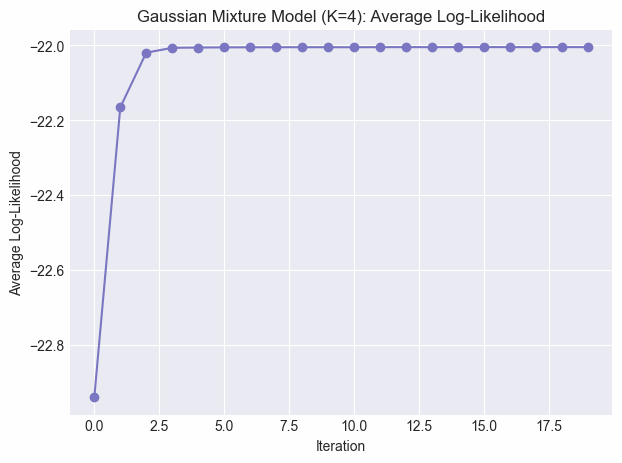

In [26]:
plt.figure(figsize=(7,5))
plt.plot(avg_log, marker='o')
plt.title("Gaussian Mixture Model (K=4): Average Log-Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Average Log-Likelihood")
plt.grid(True)
plt.show()

### (iii)

In [27]:
clustered_df, centroids, errors = K_means(df1, K=4)

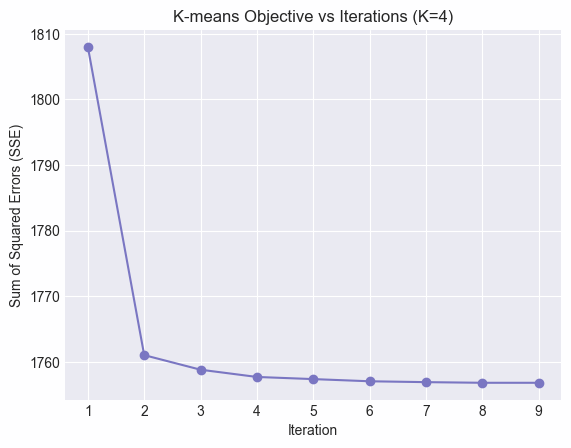

In [28]:
plt.plot(range(1, len(errors)+1), errors, marker='o')
plt.title('K-means Objective vs Iterations (K=4)')
plt.xlabel('Iteration')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

## **Question2**

The analytical or closed-form solution for the least squares weight vector, $w_{ML}$, is found by solving the normal equation for $w$:

$$
w_{ML} = (X^{T} X)^{-1} X^{T} y
$$

This solution requires the matrix $(X^{T} X)$ to be invertible. If it's not invertible (i.e., it's a singular matrix), a unique analytical solution does not exist.


In [29]:
X_train = df2.iloc[:, 0:100]
Y_train = df2.iloc[:, 100]
X_test = df2_test.iloc[:, 0:100]
Y_test = df2_test.iloc[:, 100]

**i. Obtain the least squares solution wML to the regression problem using the analytical solution.**

In [30]:
ModelA = LinReg()
w_A = ModelA.Fit(X_train,Y_train)
y_hat_A = ModelA.Test(X_test)
Rsq_A = ModelA.Eval(y_hat_A, Y_test)
print(Rsq_A)

-0.6293007863400959


In [31]:
print(f"Analytical Solution {w_A}")

Analytical Solution [[ 1.92296782e-02]
 [-8.22857431e-03]
 [-1.40735081e-02]
 [-4.02942767e-03]
 [ 2.31220049e-03]
 [ 1.88157124e-01]
 [ 2.23820069e-03]
 [ 9.11822774e-03]
 [ 1.79432430e-01]
 [ 3.32884968e-03]
 [ 4.99250666e-01]
 [ 7.98628409e-03]
 [ 3.94689677e-03]
 [ 1.38609783e-02]
 [ 3.59213519e-03]
 [ 8.95875251e-03]
 [-1.39801208e-03]
 [ 3.00560682e-03]
 [ 8.39456870e-04]
 [-9.80758686e-03]
 [-2.86553614e-03]
 [-1.21436606e-02]
 [-1.05889398e-02]
 [ 7.54500426e-03]
 [-1.04598177e-02]
 [ 5.75759845e-03]
 [-5.05271341e-03]
 [-3.41199334e-03]
 [ 7.73777158e-03]
 [ 1.16039534e-02]
 [-7.23226017e-03]
 [-8.98924102e-03]
 [ 6.16057646e-04]
 [ 4.57696299e-03]
 [ 5.58297064e-03]
 [-1.38113067e-02]
 [ 7.16306786e-04]
 [ 1.28915820e-02]
 [-1.18363478e-02]
 [-2.05111364e-02]
 [ 5.84691974e-01]
 [ 1.37222514e-05]
 [-1.18194742e-03]
 [-3.11318620e-03]
 [-9.89442065e-03]
 [-5.82715877e-03]
 [ 9.37398615e-03]
 [-7.15157795e-03]
 [-8.01112789e-04]
 [ 6.61921839e-03]
 [ 3.12067233e-02]
 [ 4.513544

In [32]:
X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

**ii. Code the gradient descent algorithm with suitable step size to solve the least squares algorithms and plot ∥wt − wML∥2 as a function of t. What do you observe?**

In [33]:
ModelB = LinReg()
w_B, res_B = ModelB.Fit(X_train, Y_train, alpha=0.001, epoch=100000, method = 'Batch_GD', capture_cost = True)
y_hat_B = ModelB.Test(X_test)
Rsq_B = ModelB.Eval(y_hat_B, Y_test)
print(Rsq_B)

-0.6184380162921914


In [34]:
normB = []
for wi in res_B:
    normB.append(np.linalg.norm(w_B - wi))

In [35]:
plt.style.use('./pitayasmoothie-light.mplstyle')

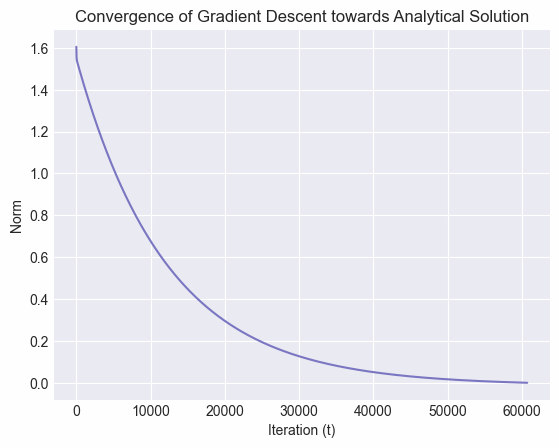

In [36]:
plt.plot(normB)
plt.xlabel("Iteration (t)")
plt.ylabel("Norm")
plt.title("Convergence of Gradient Descent towards Analytical Solution")
plt.grid(True)
plt.show()

**iii. Code the stochastic gradient descent algorithm using batch size of 100 and plot ∥wt −wML∥2 as a function of t. What are your observations?**

In [ ]:
ModelC = LinReg()
w_C, res_C = ModelC.Fit(X_train_std, Y_train, alpha=0.001, epoch=100000, method = 'MiniBatch_GD', capture_cost = True, batch_size=100)
y_hat_C = ModelC.Test(X_test_std)
Rsq_C = ModelC.Eval(y_hat_C, Y_test)
print(Rsq_C)

In [ ]:
normC = []
for wi in res_C:
    normC.append(np.linalg.norm(w_C - wi))

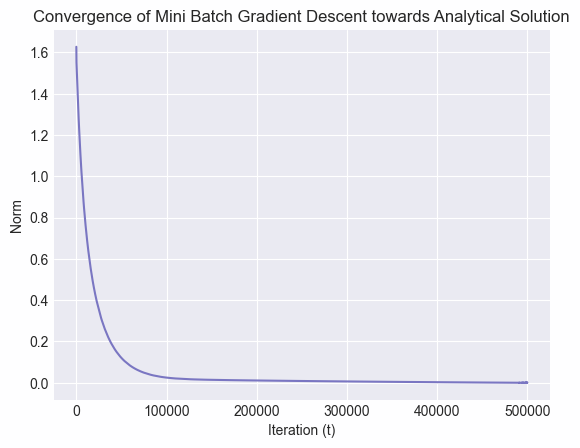

In [ ]:
plt.plot(normC)
plt.xlabel("Iteration (t)")
plt.ylabel("Norm")
plt.title("Convergence of Mini Batch Gradient Descent towards Analytical Solution")
plt.grid(True)
plt.show()

In [ ]:
X_train = df2_train.iloc[:,:-1].to_numpy()
y_train = df2_train.iloc[:,-1].to_numpy().reshape(-1,1)
X_test = df2_test.iloc[:,:-1].to_numpy()
y_test = df2_test.iloc[:,-1].to_numpy().reshape(-1,1)

In [ ]:

X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))

In [ ]:

lambdas = [ 0, 0.001, 0.01, 0.1, 1, 10, 100]
errors = cross_validate(X_train, y_train, lambdas, k=5, alpha=0.001, epochs=5000)

In [ ]:

best_lambda = lambdas[np.argmin(errors)]
print("Best λ:", best_lambda)

wR = ridge_gd(X_train, y_train, alpha=0.001, lambda_=best_lambda, epochs=20000)

wML = np.linalg.inv(X_train.T @ X_train + best_lambda * np.eye(X_train.shape[1])) @ X_train.T @ y_train

mse_R = mse(y_test, X_test @ wR)
mse_ML = mse(y_test, X_test @ wML)

print("Test MSE (Gradient Descent Ridge):", mse_R)
print("Test MSE (Closed-form Ridge):", mse_ML)

Best λ: 0
Test MSE (Gradient Descent Ridge): 0.33454651416550424
Test MSE (Closed-form Ridge): 0.41081505980955435


In [ ]:
wR

array([[0.03474098],
       [0.01850825],
       [0.01794001],
       [0.01798962],
       [0.01811715],
       [0.01730031],
       [0.01832977],
       [0.01826198],
       [0.01801609],
       [0.01856215],
       [0.01850377],
       [0.01740122],
       [0.01764783],
       [0.01812797],
       [0.01799996],
       [0.01737198],
       [0.01751759],
       [0.01733398],
       [0.0169111 ],
       [0.01704708],
       [0.01679189],
       [0.01761417],
       [0.01723796],
       [0.01701903],
       [0.01769534],
       [0.01807395],
       [0.01708764],
       [0.01668106],
       [0.01690671],
       [0.01699286],
       [0.01691099],
       [0.0170265 ],
       [0.01720168],
       [0.01713152],
       [0.01743717],
       [0.01799991],
       [0.01785402],
       [0.01757469],
       [0.01819185],
       [0.01723602],
       [0.01749404],
       [0.0169982 ],
       [0.01760329],
       [0.0171941 ],
       [0.01714072],
       [0.017195  ],
       [0.01638685],
       [0.016

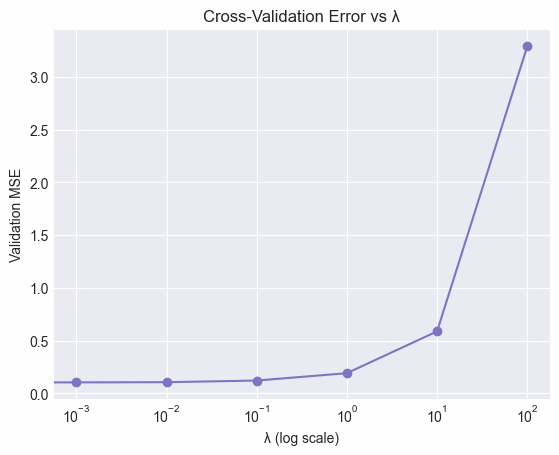

In [ ]:
plt.plot(lambdas, errors, marker='o')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Validation MSE')
plt.title('Cross-Validation Error vs λ')
plt.show()